# Text classification using Tensorflow: Stars on Reviews


This notebook trains a binary classifier for sentiment analysis to classify restaurant food reviews as *1/2 stars* or *5 stars*, based on the text of the review. 


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import warnings
import pandas as pd
import shutil
import datetime
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat May 21 20:40:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Reproducibility in TF
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

# Preprocess the data 

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Remove comma from tokenize to make one string
df['cleanReview'] = df['cleanReview'].apply(lambda x: ','.join(map(str, x)))
df.loc[:,'cleanReview'] =  df['cleanReview'].str.replace(r',', ' ', regex=True)
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,wonderful place get lunch staff friendly effic...
3,5.0,dedicated loving memory gary feldman greatest ...
5,5.0,love place everything menu delicious like tuna...
7,5.0,truely hidden gem place greatest buffalo chick...
9,5.0,seriously great fresh fantastic food spot pric...


In [ ]:
# Recode to binary
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Sample the number of reviews to balance with sentiment
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
# Sample the number of reviews to balance with sentiment
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)

# Combine sampled groups 
df1 = pd.concat([df1, df2])
df1 = shuffle(df1)

del df2

df1.shape

(829874, 2)

In [ ]:
# Convert data types
df[['cleanReview']] = df[['cleanReview']].astype('str')
df['stars_reviews'] = df['stars_reviews'].astype('float32')

In [ ]:
# Set up features and label
features = df['cleanReview']
labels = df['stars_reviews']

In [ ]:
# Load pandas df to tf
df = tf.data.Dataset.from_tensor_slices((features, labels))

In [ ]:
# Define components for paritioning data
df_size = df.cardinality().numpy()
train_size = int(0.8 * df_size)
val_size = int(0.10 * df_size)
test_size = int(0.10 * df_size)
BATCH_SIZE = 1

In [ ]:
# Prepare train/test sets
df = df.shuffle(800_000, seed=42, reshuffle_each_iteration=False)
train = df.take(train_size).batch(BATCH_SIZE) 
test = df.skip(train_size)
val = test.skip(val_size).batch(BATCH_SIZE) 
test = test.take(test_size).batch(BATCH_SIZE) 

print('Train data split:', len(train))
print('Eval data split', len(val))
print('Test data split', len(test))

Train data split: 1233188
Eval data split 154150
Test data split 154148


# Sentiment analysis




### Prepare the data for training

Next, the reviews are tokenized and vectorized using `tf.keras.layers.TextVectorization` layer. Tokenization refers to splitting strings into single words, or tokens. Vectorization converts the tokens into numbers as input for the neural network. Unique integer indices are created for each token by using `output_mode` = `int`. The `max_features` and `sequence_length` are defined for what is sampled.


In [ ]:
max_features = 50000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

The preprocessing layer is fit to the dataset by using `adapt` for the training data, which results in the model creating an index of strings to integers.

In [ ]:
# Make a review-only dataset and then call adapt
train_text = train.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

Now, define a function to examine how the created layer preprocesses the data:



In [ ]:
def vectorize_text(cleanReview, stars_reviews):
  cleanReview = tf.expand_dims(cleanReview, -1)
  return vectorize_layer(cleanReview), stars_reviews

In [ ]:
# Sample a batch reviews and labels
text_batch, label_batch = next(iter(train))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', first_label)
print('Vectorized review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'ordered sausage mama first spicy pie spicy good bland much cheese sausage get together east glisan wayyy better', shape=(), dtype=string)
Label tf.Tensor(0.0, shape=(), dtype=float32)
Vectorized review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[   16,   491,  2730,    36,   215,   471,   215,     4,   295,
           46,    65,   491,    11,   518,  1218, 14469,  7798,    48,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

Then, apply the `TextVectorization` layer to the train, validation, and test sets.

In [ ]:
train_ds = train.map(vectorize_text)
val_ds = val.map(vectorize_text)
test_ds = test.map(vectorize_text)

Configure the dataset for performance by using `.cache()` and `.prefetch()`.




In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define the model architecture, loss function and optimzer

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`. 
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

#### Loss function and optimizer

For the loss function, `losses.BinaryCrossentropy` is used for binary classification and `adam` is used as the optimizer for training. Then, the model is configured to use the defined optimizer and a loss function:

In [ ]:
# Define embedding layer size
embedding_dim = 32

In [ ]:
# Model architecture
model = tf.keras.Sequential([layers.Embedding(max_features + 1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dense(1)]) 

# Compile model
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          1600032   
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,600,065
Trainable params: 1,600,065
Non-trainable params: 0
______________________________________________

In [ ]:
# Set path for results
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/BoW/ReviewStars/Models/

In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'RS_BoW_weights_only_batch1_10epochs.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_binary_accuracy', 
                                  save_best_only=True, mode='max'), 
                  tensorboard_callback]

### Train the model


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=10, callbacks=callbacks_list)

Epoch 1/10
663899/663899 [==============================] - 3702s 6ms/step - loss: 0.1316 - binary_accuracy: 0.9548 - val_loss: 0.1130 - val_binary_accuracy: 0.9643
Epoch 2/10
663899/663899 [==============================] - 3595s 5ms/step - loss: 0.1130 - binary_accuracy: 0.9626 - val_loss: 0.1112 - val_binary_accuracy: 0.9646
Epoch 3/10
663899/663899 [==============================] - 3623s 5ms/step - loss: 0.1105 - binary_accuracy: 0.9637 - val_loss: 0.1110 - val_binary_accuracy: 0.9643
Epoch 4/10
663899/663899 [==============================] - 3640s 5ms/step - loss: 0.1093 - binary_accuracy: 0.9641 - val_loss: 0.1108 - val_binary_accuracy: 0.9642
Epoch 5/10
663899/663899 [==============================] - 3658s 6ms/step - loss: 0.1089 - binary_accuracy: 0.9644 - val_loss: 0.1111 - val_binary_accuracy: 0.9640
Epoch 6/10
663899/663899 [==============================] - 3647s 5ms/step - loss: 0.1083 - binary_accuracy: 0.9647 - val_loss: 0.1107 - val_binary_accuracy: 0.9642
Epoch 7/10

In [ ]:
# Save model
model.save('./RS_BoW_batch1_10epochs_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'RS_BoW_weights_only_batch1_10epochs.h5'
#model = tf.keras.models.load_model('./RS_BoW_batch1_10epochs_tf.h5')
#model.load(weights)

# Show the model architecture
#model.summary()

### Plot loss and accuracy over training

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

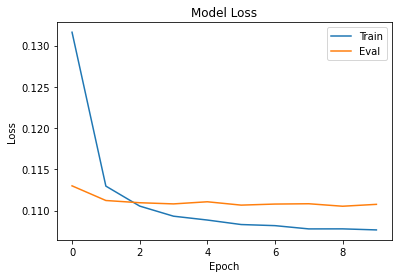

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('RS_BoW_batch1_10Epochs_Loss.png', dpi=my_dpi*10, 
            bbox_inches='tight')
plt.show()

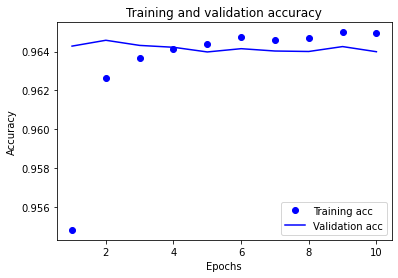

In [ ]:
# Plot accuracy over epochs
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('RS_BoW_batch1_10Epochs_Accuracy.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

- The training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. However, this is not true for the validation loss and accuracy. 

- The baseline model demonstrates overfitting because the model performs better on the training data than it does on data it has never seen before (validation data). The model over-optimizes and learns representations *specific* to the training data that do not *generalize* to validation data.

- Decreasing the patience for early stopping could prevent overfitting and optimizing the hyperparameters of the model could also help.

### Evaluate the model on the test set

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

82987/82987 [==============================] - 161s 2ms/step - loss: 0.1095 - binary_accuracy: 0.9645
Loss:  0.10945954918861389
Accuracy:  0.9644643068313599


This approach yields an accuracy around 96%.

## Export the model

To export the model for deployment, a new model is created using the trained weights with the `TextVectorization` layer inside the model, allowing it to process text strings.

In [ ]:
export_model = tf.keras.Sequential([vectorize_layer,
                                    model, layers.Activation('sigmoid')])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), 
                     optimizer='adam', metrics=['accuracy'])

# Evaluate on test set, which yields raw strings
loss, accuracy = export_model.evaluate(test)
print(accuracy)

82987/82987 [==============================] - 174s 2ms/step - loss: 0.1095 - accuracy: 0.9645
0.9644643068313599


### Inference on new data


In [ ]:
for row in test.take(10):
  print(row)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'never disappointed visit cheesecake factory food super good portion huge tend split dish someone order extra side still leave super full always leave room dessert'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'ridiculous place vancouver went twice opened time famous mama poke bowl never go back absolute waste time first time went food mediocre'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'flight attendant landed portland crew starving limited time flight decided cafe yumm greeted richard helpful genuine willing go extra mile help choose menu explained time crunch said problem jumped behind counter help expedite order kitchen truly bright spot day fabulous employee food excellent exactly wanted thank much richard come wor

In [ ]:
examples = [
  'never disappointed visit cheesecake factory food super good portion huge tend split dish someone order extra side still leave super full always leave room dessert',
  'ridiculous place vancouver went twice opened time famous mama poke bowl never go back absolute waste time first time went food mediocre',
  'flight attendant landed portland crew starving limited time flight decided cafe yumm greeted richard helpful genuine willing go extra mile help choose menu explained time crunch said problem jumped behind counter help expedite order kitchen truly bright spot day fabulous employee food excellent exactly wanted thank much richard come work enthusiasm positive energy looking',
  'overpriced bland food definitely worth skipping',
  'tonight experience never come stop n shop everything possibly never shop stop n shop store absolutely filthy understaffed low inventory literally order inventory purchase item need week week multiple sale item stock week instead whomever stocking item putting item place make look like shelf full chronic issue get fact wait line minute every time come non peak hour like tonight monday night pm always wait line minute never register open shop pm usually get fact store dirty tonight unfathomable freezer leaking wet floor sign wad soaked paper towel floor well puddle water middle aisle avoid order keep food store cold ac set beyond acceptable could figure freezer section wearing jean sweatshirt losing feeling hand legitimately people talking went every aisle lastly probably importantly majority produce look unsellable meat close second barely wrapped leaking well respect think place need shut cleaned reopened',
  'let tell general tso expert think fried chicken light breading put sauce fried made really delicious crystallized bit spicy sweet goodness bad piece chicken bunch wonton soup great fried shumai delicious thai egg roll sweet chili sauce good service perfect restaurant clean wait go back',
  'bacon egg cheese round potato taco favorite breakfast town good',
  'changed canteen menu changed suck shame used favourite place longer serve platter bowl wrap even make potato anymore',
  'food good experience left something desired sat counter ordered fairly large meal one coffee two people wife drink much coffee server counter already gave funny look coffee served already spilled one quarter cup cup ounce upon settling check asked refill coffee met buy another coffee share seriously offputting think individual drink cup coffee anyway breakfast even get one refill cup spilled cup coffee like th cup coffee anything frequent place time enough make want go back think people sitting back part restaurant sharing coffee seriously mistaken way petty',
  'came dinner inlaws last night food well par also opportunity meet owner head chef fantastic guy great personality extremely personable additional star another great experience thank seven rivers'
]

export_model.predict(examples)

array([[9.7133732e-01],
       [1.1439980e-01],
       [6.7619747e-01],
       [8.3185053e-01],
       [3.4674813e-04],
       [9.9324644e-01],
       [8.5916173e-01],
       [1.6273072e-01],
       [9.9135029e-01],
       [4.5830286e-03]], dtype=float32)